# HHNK

This script adds a new column "peilgebied_cat" and makes sure the peilgebieden allign with the HWS layer (Daniel):
- peilgebied_cat = 0 -> peilgebied
- peigelbied_cat = 1 -> RHWS (boezem)
- peilgebied_cat = 2 -> NHWS 

In [69]:
import geopandas as gpd
import numpy as np
from general_functions import *

%load_ext autoreload
%autoreload 2

remove_cat_2 = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Paths

In [70]:
# define relative paths
waterschap = "HHNK"
waterschap2 = "Noorderkwartier"

data_path = f"/DATAFOLDER/projects/4750_20/Data_postprocessed/Waterschappen/{waterschap}/{waterschap2}.gpkg"

# Waterschaps boundaries
grens_path = "/DATAFOLDER/projects/4750_30/Data_overig/Waterschapsgrenzen/Waterschapsgrenzen.geojson"
# Hoofdwatersysteem boundaries
hws_path = "/DATAFOLDER/projects/4750_30/Data_overig/HWS/krw_basins_vlakken.gpkg"
# Buffer boundaries
buffer_path = "/DATAFOLDER/projects/4750_30/Data_overig/HWS/hws_buffer_hhnk.gpkg"
# Output folder
output_folder = f"/DATAFOLDER/projects/4750_30/Data_postprocessed/Waterschappen/{waterschap}"

## Load files

In [71]:
# Load HHNK files
HHNK = read_gpkg_layers(
    gpkg_path=data_path,
    variables=[
        "stuw",
        "gemaal",
        "hydroobject",
        "duikersifonhevel",
        "peilgebied",
        "streefpeil",
        "aggregation_area",
    ],
)
HHNK["peilgebied"] = HHNK["peilgebied"].to_crs("EPSG:28992")

# Load waterschap boundaries
gdf_grens = gpd.read_file(grens_path)
gdf_grens = gdf_grens.to_crs("EPSG:28992")
gdf_grens = gdf_grens.set_index("waterschap")

# Load hws
gdf_hws = gpd.read_file(hws_path)

# Load buffer
gdf_buffer = gpd.read_file(buffer_path)

## Select waterschap boundaries and clip hws layer

In [72]:
# Select boundaries HH Amstel, Gooi en Vecht
gdf_grens = gdf_grens.loc[["HH Hollands Noorderkwartier"]]

# Use waterschap boudnaries to clip HWS layer
gdf_hws = gpd.overlay(gdf_grens, gdf_hws, how="intersection")

## Peilgebied and HWS layer overlap:
1. Identify the overlapping areas
2. Clip
3. Calculate overlapping area percentage
4. Filter

<Axes: >

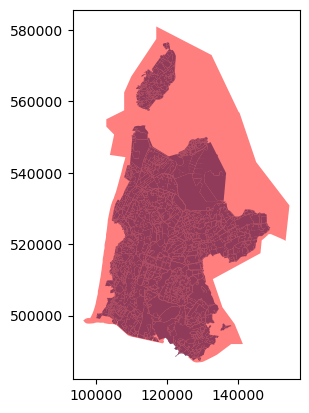

In [73]:
# Plot
fig, ax = plt.subplots()

HHNK["peilgebied"].plot(ax=ax)
gdf_grens.plot(ax=ax, color="red", alpha=0.5)

In [74]:
HHNK["peilgebied"].geometry.type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [75]:
HHNK["peilgebied"].geometry = HHNK["peilgebied"].buffer(0)
gdf_grens.geometry = gdf_grens.buffer(0)

In [76]:
# Step 1: Identify the Overlapping Areas and clip.
HHNK["peilgebied"] = gpd.overlay(HHNK["peilgebied"], gdf_grens, how="intersection", keep_geom_type=True)
overlaps = gpd.overlay(HHNK["peilgebied"], gdf_hws, how="intersection", keep_geom_type=True)

# # Step 2: Subtract Overlapping Areas from the original polygons in each DataFrame
non_overlapping_peilgebied = gpd.overlay(HHNK["peilgebied"], overlaps, how="difference", keep_geom_type=True)
overlaps = gpd.overlay(non_overlapping_peilgebied, gdf_hws, how="intersection", keep_geom_type=False)

# Step 3: Calculate Area Percentages
# Calculate the area of overlaps
overlaps["overlap_area"] = overlaps.area

# Step 4: Filter based on area Area Percentages
minimum_area = 20000
print(f"Number of overlapping shapes without filter: {len(overlaps)}")
overlap_ids = overlaps.loc[overlaps["overlap_area"] > minimum_area]
overlap_ids = overlap_ids.globalid.to_list()
print(f"Number of overlapping shapes with filter: {len(overlap_ids)}")

Number of overlapping shapes without filter: 61
Number of overlapping shapes with filter: 0


## Create peilgebied_cat column

In [77]:
# Add occurence to geodataframe
peilgebieden_cat = []

# code_list = ["dummy_code_5188","dummy_code_5161","dummy_code_5210","dummy_code_4352","dummy_code_5164","dummy_code_5200","dummy_code_5167","dummy_code_37"]


for index, row in HHNK["peilgebied"].iterrows():
    if row.HWS_BZM:
        print("yes")
        peilgebieden_cat.append(1)

    # elif row.HWS_BZM is True:
    #     peilgebieden_cat.append(1)

    else:
        peilgebieden_cat.append(0)

# Add new column and drop old HWS_BZM column
HHNK["peilgebied"]["peilgebied_cat"] = peilgebieden_cat
# HHNK['peilgebied'] = HHNK['peilgebied'].drop(columns=['HWS_BZM'])

yes
yes
yes
yes


## Add nhws to ['peilgebied','streefpeil']

In [78]:
# update peilgebied dict key
gdf_hws["globalid"] = "dummy_globalid_nhws_" + gdf_hws.index.astype(str)
gdf_hws["code"] = "dummy_code_nhws_" + gdf_hws.index.astype(str)
gdf_hws["nen3610id"] = "dummy_nen3610id_nhws_" + gdf_hws.index.astype(str)
gdf_hws["peilgebied_cat"] = 2

gdf_hws = gdf_hws[["globalid", "code", "nen3610id", "peilgebied_cat", "geometry"]]

HHNK["peilgebied"] = pd.concat([gdf_hws, HHNK["peilgebied"]])

In [79]:
# Create boezem streefpeil layer
streefpeil_hws = pd.DataFrame()
streefpeil_hws["waterhoogte"] = [np.nan] * len(gdf_hws)
streefpeil_hws["globalid"] = "dummy_globalid_nhws_" + gdf_hws.index.astype(str)
streefpeil_hws["geometry"] = [None] * len(gdf_hws)

HHNK["streefpeil"] = pd.concat([streefpeil_hws, HHNK["streefpeil"]])
HHNK["streefpeil"] = gpd.GeoDataFrame(HHNK["streefpeil"])

### Create layer that ensures spatial match between peilgebied and hws layers based on the buffer layer

In [80]:
# # Create buffer polygon
# buffer_polygon = gpd.overlay(gdf_buffer, gdf_grens, how='intersection', keep_geom_type=True)
# buffer_polygon = gpd.overlay(buffer_polygon, gdf_hws, how='difference', keep_geom_type=True)


# # Apply a small buffer to both GeoDataFrames to "clean" the geometries
# buffer_polygon.geometry = buffer_polygon.buffer(0.001).buffer(-0.001)
# HHNK['peilgebied'].geometry = HHNK['peilgebied'].buffer(0.001).buffer(-0.001)

# # Try the overlay operation again
# try:
#     buffer_polygon = gpd.overlay(buffer_polygon, HHNK['peilgebied'], how='difference', keep_geom_type=True)
#     print("Overlay operation successful.")
# except Exception as e:
#     print(f"Overlay operation failed: {e}")

## Add buffer to ['peilgebied','streefpeil']

In [81]:
# # update peilgebied dict key
# buffer_polygon['globalid'] = 'dummy_globalid_nhws_buffer_' + buffer_polygon.index.astype(str)
# buffer_polygon['code'] = 'dummy_code_nhws_buffer_' + buffer_polygon.index.astype(str)
# buffer_polygon['nen3610id'] = 'dummy_nen3610id_nhws_buffer_' + buffer_polygon.index.astype(str)
# buffer_polygon['peilgebied_cat'] = 2

# buffer_polygon = buffer_polygon[['globalid', 'code', 'nen3610id', 'peilgebied_cat', 'geometry']]

# HHNK['peilgebied'] = pd.concat([buffer_polygon, HHNK['peilgebied']])

In [82]:
# # Create boezem streefpeil layer
# streefpeil_buffer = pd.DataFrame()
# streefpeil_buffer['waterhoogte'] = [np.nan]
# streefpeil_buffer['globalid'] = ['dummy_globalid_nhws_buffer_1']
# streefpeil_buffer['geometry'] = [None]


# HHNK['streefpeil'] = pd.concat([streefpeil_buffer, HHNK['streefpeil']])
# HHNK['streefpeil'] = gpd.GeoDataFrame(HHNK['streefpeil'])



In [83]:
HHNK["peilgebied"] = HHNK["peilgebied"][["globalid", "code", "nen3610id", "peilgebied_cat", "geometry"]]

In [84]:
if remove_cat_2:
    HHNK["peilgebied"] = HHNK["peilgebied"].loc[HHNK["peilgebied"].peilgebied_cat != 2]

## Write output

In [85]:
for key in HHNK.keys():
    print(key)
    HHNK[str(key)].to_file(f"{output_folder}/{waterschap2}.gpkg", layer=str(key), driver="GPKG")

stuw
gemaal
hydroobject
duikersifonhevel
peilgebied
streefpeil
aggregation_area


In [86]:
HHNK["peilgebied"]["peilgebied_cat"].unique()

array([0, 1])